# Sales Prediction(Online and Offline)
Model used : Random Forest Regressor

Step 1: Import Libraries

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

Step 2: Import and Merge Data

In [225]:
def import_data(sales, orders):
    # Load data from CSV files
    sales_data = pd.read_csv(sales)
    orders_data = pd.read_csv(orders)
    merged_data = pd.merge(sales_data, orders_data, on='order_id')
    return merged_data

In [226]:
data = import_data("sales.csv", "orders.csv")
print(data.head())

   sales_id  order_id  product_id  price_per_unit  quantity  total_price  \
0         0         1         218             106         2          212   
1         1         1         481             118         1          118   
2         2         1           2              96         3          288   
3         3         1        1002             106         2          212   
4         4         1         691             113         3          339   

   customer_id  payment order_date delivery_date  
0           64    30811  2021-8-30    2021-09-24  
1           64    30811  2021-8-30    2021-09-24  
2           64    30811  2021-8-30    2021-09-24  
3           64    30811  2021-8-30    2021-09-24  
4           64    30811  2021-8-30    2021-09-24  


Step 3: Process data and generate data for purchase mode

Purchase mode 1 = online, 0 = offline

In [227]:
def prepare_data(data):

    # Extract month and year from order date
    data['order_date'] = pd.to_datetime(data['order_date'])
    data['year'] = data['order_date'].dt.year
    data['month'] = data['order_date'].dt.month

    # Calculate monthly sales
    monthly_sales = data.groupby(['year', 'month']).agg({'total_price': 'sum'}).reset_index()

    # Add a new column for online purchase (randomly generate 0 or 1) 
    monthly_sales['purchase_mode'] = np.random.randint(0, 2, size=len(monthly_sales))
    return monthly_sales


In [228]:
past_monthly_sales = prepare_data(data)
print(past_monthly_sales.head())

   year  month  total_price  purchase_mode
0  2021      1       119333              0
1  2021      2        95080              1
2  2021      3       131364              0
3  2021      4        97530              1
4  2021      5        85597              1


Step 4: Predict next year's sales using Random Forrest Regressor


Note: We only have 2021's data so we cannot split it into test and train set. Ideally we could have tested 2023's data against 2020 and 2021

In [229]:
def predict_sales(monthly_sales):
    X = monthly_sales[['year', 'month', 'purchase_mode']]
    y = monthly_sales['total_price']
    
    # Train the model using all available data
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X, y)
    
    # Make predictions for the next 12 months
    future_df = pd.DataFrame({'year': [2022] * 12, 'month': range(1, 13), 'purchase_mode': [0] * 12})
    predicted_sales = rf_model.predict(future_df)
    return predicted_sales

In [230]:
predicted_monthly_sales = predict_sales(past_monthly_sales)

Step 5: Visualise the past and future sales

(Note: Since purchase mode(online and offline) are randomly generated values, some months might only have online or offline sale due to the random nature. Sales prediction will be more accurate if online/offline purchase mode is not randomly generated)

In [231]:
def visualise(past_sales, predicted_sales):
    # Plot actual and predicted sales for both online and offline purchases
    fig, graph = plt.subplots(2, figsize=(10, 10))
    
    # Plot for offline purchases
    offline_sales = past_sales[past_sales['purchase_mode'] == 0]
    graph[0].plot(offline_sales.index[-12:], offline_sales['total_price'].tail(12), marker='o', color='green', label='Actual Offline Sales 2021')
    graph[0].plot(range(12), predicted_sales, marker='x', color='blue', linestyle='--', label='Predicted Offline Sales 2022')
    graph[0].set_title('Offline Sales')
    graph[0].set_xlabel('Month')
    graph[0].set_ylabel('Total Sales (in dollars)')
    graph[0].legend()
    
    # Plot for online purchases
    online_sales = past_sales[past_sales['purchase_mode'] == 1]
    graph[1].plot(online_sales.index[-12:], online_sales['total_price'].tail(12), marker='o', color='green', label='Actual Online Sales 2021')
    graph[1].plot(range(12), predicted_sales, marker='x', color='blue', linestyle='--', label='Predicted Online Sales 2022')
    graph[1].set_title('Online Sales')
    graph[1].set_xlabel('Month')
    graph[1].set_ylabel('Total Sales (in dollars)')
    graph[1].legend()
    
    plt.tight_layout()
    plt.show()

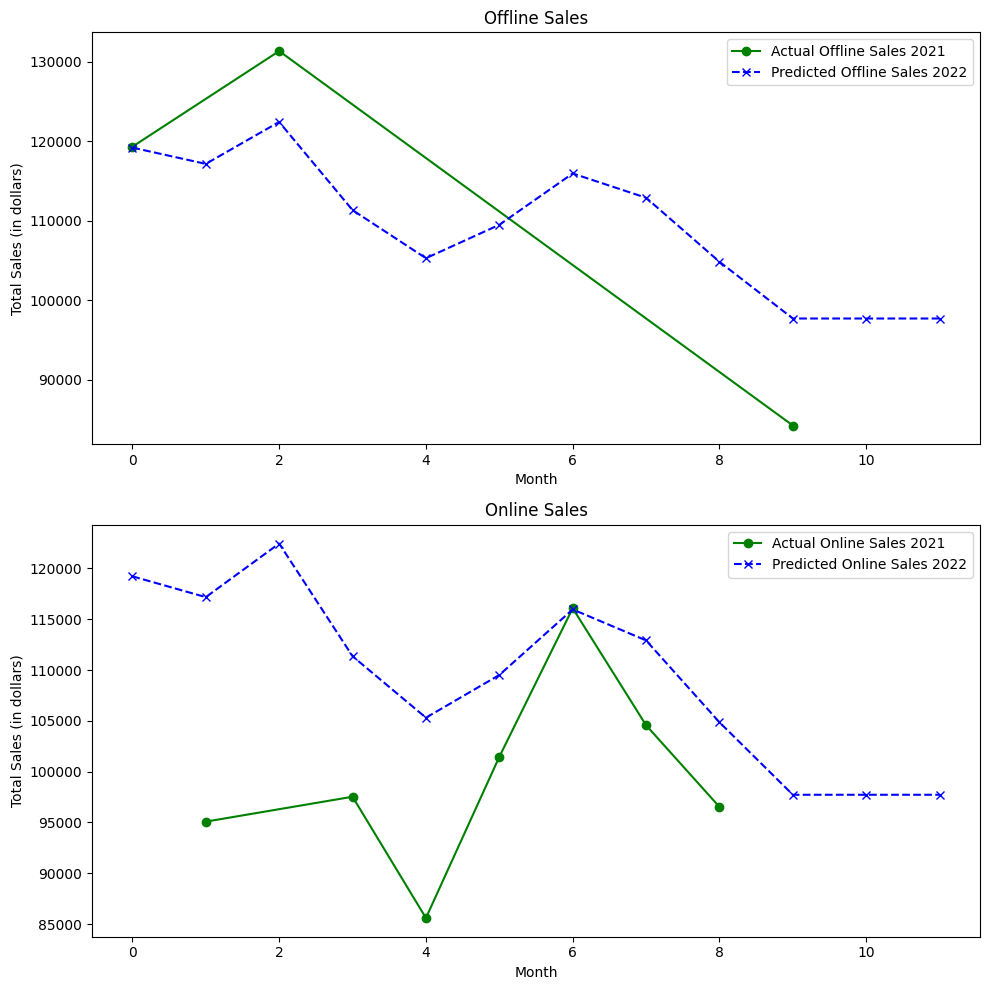

In [232]:
visualise(past_monthly_sales, predicted_monthly_sales)

**Additional Analysis**

Let's assume all sales are online and predict future sales for only online purchases
i.e. this time we don't randomly generate purchase_mode for monthly sales

In [233]:
def prepare_online_data(data):

    # Extract month and year from order date
    data['order_date'] = pd.to_datetime(data['order_date'])
    data['year'] = data['order_date'].dt.year
    data['month'] = data['order_date'].dt.month

    # Calculate monthly sales
    monthly_sales = data.groupby(['year', 'month']).agg({'total_price': 'sum'}).reset_index()

    return monthly_sales

In [234]:
past_online_sales = prepare_online_data(data)
print(past_online_sales.head())

   year  month  total_price
0  2021      1       119333
1  2021      2        95080
2  2021      3       131364
3  2021      4        97530
4  2021      5        85597


Let's apply Random Forrest Regressor, also let's try splitting data into train and test.

This time we will also validate our model.

An MSE of less implies that the model is more accurate in predicting the target variable, whereas an MSE of higher value implies that the model's predictions deviate more from the actual values.

In [235]:
def predict_online_sales(past_online_sales):
        X = past_online_sales[['year', 'month']]
        y = past_online_sales['total_price']

        # Split data into train and test (70% train, 30% test)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        rf_model = RandomForestRegressor()
        rf_model.fit(X_train, y_train)

        # Make predictions for the next 12 months
        future_months = pd.DataFrame({'year': [2022] * 12, 'month': range(1, 13)})
        predicted_online_sales = rf_model.predict(future_months)

        #Test model on the test set
        y_pred = rf_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        
        print("Mean Squared Error:" , mse)

        return predicted_online_sales

In [236]:
predicted_online_sales = predict_online_sales(past_online_sales)

Mean Squared Error: 236948071.0592332


Visualise results

In [237]:
def visualise(past_sales, predicted_sales):
    # Plot actual and predicted sales for online purchases
    plt.figure(figsize=(10, 6))
    
    # Plot for offline purchases
    plt.plot(past_sales.index[-12:], past_sales['total_price'].tail(12), marker='o', color='green', label='Actual Offline Sales 2021')
    plt.plot(range(12), predicted_sales, marker='x', color='blue', linestyle='--', label='Predicted Offline Sales 2022')
    plt.title('Offline Sales')
    plt.xlabel('Month')
    plt.ylabel('Total Sales (in dollars)')
    plt.legend()
    
    plt.show()

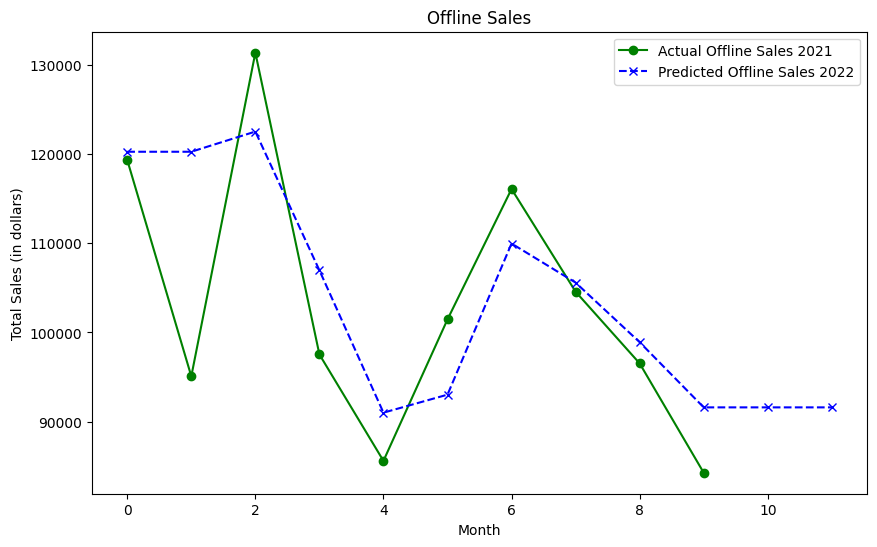

In [239]:
visualise(past_online_sales, predicted_online_sales)